In [1]:
import torch
import torch.nn as nn
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from tqdm import tqdm
import quantecon as qe

# Set device - use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Difference to the Ramsey code

- We have two states $(K_{t-1},Z_t)$ and we need to take an expectation with respect to innovations to TFP $\varepsilon_t$ 
- We add a function to draw $Z_t$ from its ergodic distribution
- We add a function to compute the expectation with Monte-Carlo

That's it!

## Model Parameters

In [2]:
## Preferences
beta = 0.9 
gamma = 2.0 

## Firms
alpha = 1/3 
delta = 0.05 

## TFP 
sigma_Z = 0.001
rho_Z = 0.9
mu_Z = np.exp(1/2 * sigma_Z**2 / (1 - rho_Z**2))

In [3]:
def production_function(Z, K):
    """Cobb-Douglas production function"""
    return Z * K**alpha 

def coh_fun(Z, K):
    return production_function(Z, K) + (1 - delta) * K

def r_fun(Z, K):
    """Return the interest rate given Z and K"""
    return alpha * production_function(Z, K) / K - delta 

def c_fun(savings_rate, Z, K):
    """Consumption function given savings rate, TFP Z and capital K"""
    coh = coh_fun(Z, K)
    return (1 - savings_rate) * coh

In [4]:
# Steady-state 
r = 1/beta - 1 
Z_ss = 1
K_ss = ((r + delta) / (alpha * Z_ss))**(1/(alpha-1))
Y_ss = K_ss**alpha
C_ss = Y_ss - delta * K_ss 
savings_rate_ss = K_ss / (Y_ss + (1 - delta) * K_ss)

# bounds for endogenous state variable
Kmin = K_ss * 0.5
Kmax = K_ss * 2.5
K_grid = np.linspace(Kmin, Kmax, 500)

In [5]:
class DecisionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32), # two inputs 
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1) # one output
        )
    
    def forward(self, x):
        return self.net(x)

network = DecisionNetwork().to(device)

In [6]:
def policy_function(Z, K):
    """Decision rule: maps states to (savings_rate, h)"""
    
    # Normalize inputs to roughly [-1, 1] range
    Z_normalized = (Z-1.0) / sigma_Z / 2
    K_normalized = 2.0 * (K - Kmin) / (Kmax - Kmin) - 1.0
    
    # Stack inputs: shape (n, 2)
    s = torch.stack([Z_normalized, K_normalized], dim=1)
    
    # Forward pass through network
    x = network(s)  # (n, 1)
    
    # Savings rate in [0,1]
    savings_rate = torch.sigmoid(x[:, 0])
        
    return torch.clamp(savings_rate, min = 0.1, max = 0.9999)

In [7]:
def monte_carlo_expectation(Z, K_next, n_mc=64):
    n = K_next.shape[0]
    # ---- Monte Carlo expectation for RHS ----
    # Draw eps shocks: (batch_size, n_mc)
    eps = sigma_Z * torch.randn(n, n_mc, device=K_next.device, dtype=K_next.dtype)

    # Compute Z' in levels: Z' = exp(rho * log Z + eps)
    logZ = torch.log(Z).unsqueeze(1)            # (batch_size, 1)
    logZ_next = rho_Z * logZ + eps                # (batch_size, n_mc)
    Z_next = torch.exp(logZ_next)               # (batch_size, n_mc)

    # Expand K_next across MC draws
    K_next_mc = K_next.unsqueeze(1).expand(-1, n_mc)  # (batch_size, n_mc)

    # Flatten to evaluate functions in one shot
    Z_next_flat = Z_next.reshape(-1)            # (batch_size*n_mc,)
    K_next_flat = K_next_mc.reshape(-1)         # (batch_size*n_mc,)

    # Next-period policy and consumption
    savings_rate_next = policy_function(Z_next_flat, K_next_flat)
    C_next = c_fun(savings_rate_next, Z_next_flat, K_next_flat)

    # Future returns and marginal utility
    r_next = r_fun(Z_next_flat, K_next_flat)
    MU_next = C_next**(-gamma)

    # Monte Carlo estimate of E[(1+r') u'(C')]
    term = ((1.0 + r_next) * MU_next).reshape(n, n_mc)  # (batch_size, n_mc)
    E_term = term.mean(dim=1)                            # (batch_size,)
    return E_term

def euler_residuals(Z, K):

    # Current decisions
    savings_rate = policy_function(Z, K)
    coh = coh_fun(Z, K)
    K_next = savings_rate * coh
    C = coh - K_next

    # LHS and RHS of Euler equation
    LHS = C**(-gamma)
    E_term = monte_carlo_expectation(Z, K_next)
    RHS = beta * E_term

    # Residual
    R = RHS / LHS - 1.0
    return R


## Objective Function 

In [ ]:
def sample_Z_ergodic(n, rho, sigma_eps, *, device=None, dtype=torch.float32):
    if not (-1.0 < rho < 1.0):
        raise ValueError("Need |rho| < 1 for a stationary (ergodic) distribution.")
    device = device or torch.device("cpu")
    rho = torch.as_tensor(rho, device=device, dtype=dtype)
    sigma_eps = torch.as_tensor(sigma_eps, device=device, dtype=dtype)

    sigma_x = sigma_eps / torch.sqrt(1.0 - rho**2)          # std of log Z in stationarity
    x = sigma_x * torch.randn(n, device=device, dtype=dtype) # mean 0
    Z = torch.exp(x)
    return Z

def objective_function(n):
    # Sample current states from ergodic distribution
    Z = sample_Z_ergodic(n, rho_Z, sigma_Z, device=device)
    K = torch.rand(n, device=device) * (Kmax - Kmin) + Kmin

    # Compute Euler residual with Tauchen quadrature
    R = euler_residuals(Z, K)
    
    # Minimize squared residuals
    return torch.mean(R**2)

In [ ]:
optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
n = 128

def training_step():
    optimizer.zero_grad()
    loss = objective_function(n)  
    loss.backward()
    optimizer.step()
    return loss.item()

def train(X):
    vals = []
    for k in tqdm(range(X)):
        val = training_step()
        vals.append(val)
    return vals

In [10]:
results = train(50_000)

100%|██████████| 50000/50000 [01:33<00:00, 535.45it/s]


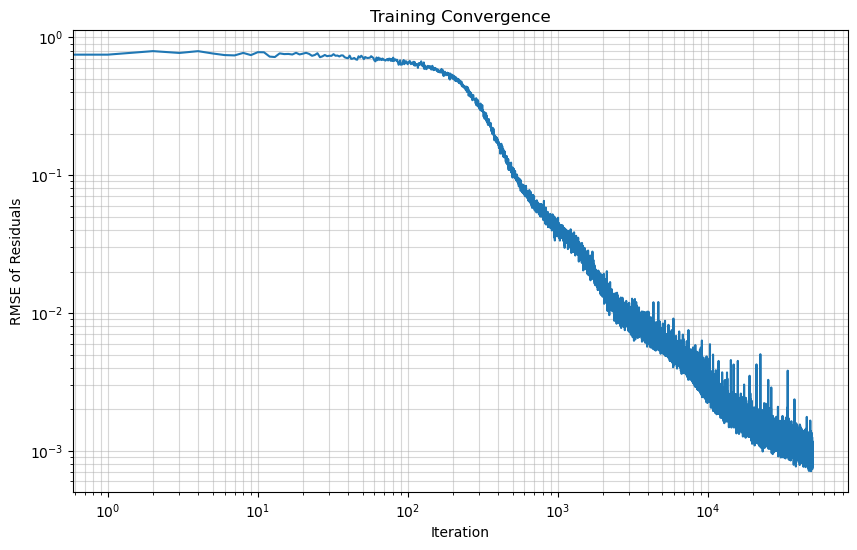

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(np.sqrt(np.abs(results)))  # abs() for numerical safety
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('RMSE of Residuals')
plt.title('Training Convergence')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

## Learned Decision Rule

In [12]:
from rbc_vfi import vfi, extract_policies, K_grid

_, policy_K = vfi(tol = 1e-6, max_iter = 1000, verbose = True)
policy_C, policy_s = extract_policies(policy_K)

Iteration 1: max value function diff = 0.60852649
Iteration 2: max value function diff = 0.34926234
Iteration 3: max value function diff = 0.21373847
Iteration 4: max value function diff = 0.13545738
Iteration 5: max value function diff = 0.10404051
Iteration 6: max value function diff = 0.09145667
Iteration 7: max value function diff = 0.08020528
Iteration 8: max value function diff = 0.07023288
Iteration 9: max value function diff = 0.06145832
Iteration 10: max value function diff = 0.05375595
Iteration 11: max value function diff = 0.04703333
Iteration 12: max value function diff = 0.04116455
Iteration 13: max value function diff = 0.03607009
Iteration 14: max value function diff = 0.03163679
Iteration 15: max value function diff = 0.02777722
Iteration 16: max value function diff = 0.02441889
Iteration 17: max value function diff = 0.02149456
Iteration 18: max value function diff = 0.01894559
Iteration 19: max value function diff = 0.01672597
Iteration 20: max value function diff = 

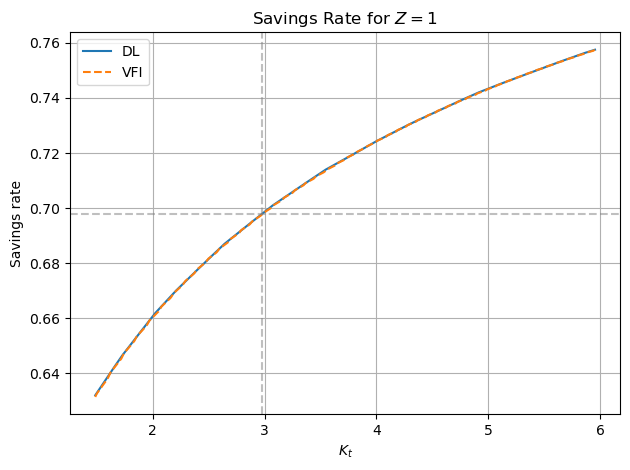

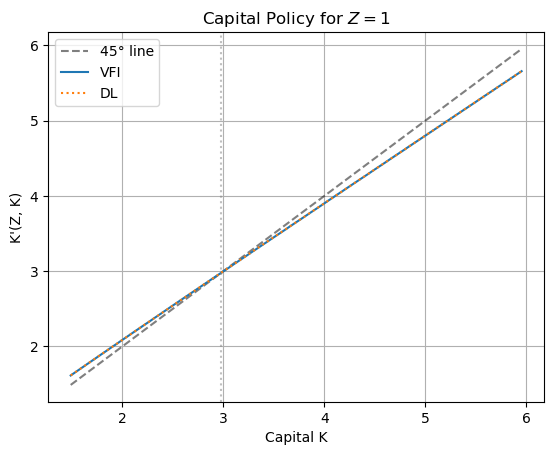

In [13]:
with torch.no_grad():
    Kvec = torch.tensor(K_grid, dtype=torch.float32, device=device)
    ones = torch.ones_like(Kvec)  # Z = 1 (level value at steady state)
    savings_rate_vec = policy_function(ones, Kvec)


plt.plot(Kvec.cpu(), savings_rate_vec.cpu(), label='DL')
plt.plot(Kvec.cpu(), policy_s[4, :], linestyle='--', label='VFI')
plt.axvline(x=K_ss, linestyle='--', color='grey', alpha=0.5)
plt.axhline(y=savings_rate_ss, linestyle='--', color='grey', alpha=0.5)
plt.xlabel("$K_t$")
plt.ylabel("Savings rate")
plt.title("Savings Rate for $Z=1$")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

coh = coh_fun(ones, Kvec)
K_next_dl = savings_rate_vec * coh
K_next_vfi = policy_s * coh.cpu().numpy()
plt.plot(Kvec.cpu(), Kvec.cpu(), 'k--', alpha=0.5, label='45° line')
plt.plot(Kvec.cpu(), K_next_vfi[4,:], label=f'VFI')
plt.plot(Kvec.cpu(), K_next_dl.cpu(), label=f'DL', linestyle = ':')
plt.axvline(x=K_ss, linestyle=':', color='gray', alpha=0.5)
plt.xlabel('Capital K')
plt.ylabel("K'(Z, K)")
plt.title('Capital Policy for $Z=1$')
plt.legend()
plt.grid()
plt.show()